Cell 0: Project root

In [1]:
from pathlib import Path
import os
import sys

# Resolve project root from notebook location
PROJECT_ROOT = Path(os.getcwd()).resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

# Make sure src/ is importable
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)

PROJECT_ROOT: C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model


Cell 1: Paths + Imports

In [2]:
import sys, os
from pathlib import Path

PROJECT_ROOT = Path(os.getcwd()).resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print("Project root:", PROJECT_ROOT)

from src.train import train_model
from src.dataset import load_eurosat_dataset
from src.models import build_model
from src.eval import evaluate_model

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

DATA_DIR = PROJECT_ROOT / "data" / "raw" / "EuroSAT_RGB"
print("Data dir:", DATA_DIR)

Project root: C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model
Device: cpu
Data dir: C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\data\raw\EuroSAT_RGB


Cell 2: Train

In [3]:
model, class_names = train_model(
    data_dir=DATA_DIR,
    model_name="resnet18",
    pretrained=True,
    freeze_backbone=True,   # train only the head
    epochs=8,
    lr=1e-3,
    batch_size=64,
    img_size=64,
    seed=42,
    aug_level="light",
    weight_decay=1e-4,
    label_smoothing=0.05,
    early_stop_patience=3,
)

Using device: cpu


Epoch 1/8: 100%|██████████| 296/296 [04:24<00:00,  1.12it/s]


Epoch 1 | Train Loss: 1.1517 | Val Acc: 0.7674 | LR: 1.00e-03
Saved BEST model so far to C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\models\resnet18_pre_frozen_best.pth (val_acc=0.7674)


Epoch 2/8: 100%|██████████| 296/296 [00:50<00:00,  5.82it/s]


Epoch 2 | Train Loss: 0.9176 | Val Acc: 0.7884 | LR: 1.00e-03
Saved BEST model so far to C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\models\resnet18_pre_frozen_best.pth (val_acc=0.7884)


Epoch 3/8: 100%|██████████| 296/296 [03:14<00:00,  1.52it/s]


Epoch 3 | Train Loss: 0.8779 | Val Acc: 0.7849 | LR: 1.00e-03


Epoch 4/8: 100%|██████████| 296/296 [01:55<00:00,  2.56it/s]


Epoch 4 | Train Loss: 0.8722 | Val Acc: 0.8005 | LR: 1.00e-03
Saved BEST model so far to C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\models\resnet18_pre_frozen_best.pth (val_acc=0.8005)


Epoch 5/8: 100%|██████████| 296/296 [00:55<00:00,  5.35it/s]


Epoch 5 | Train Loss: 0.8627 | Val Acc: 0.7980 | LR: 1.00e-03


Epoch 6/8: 100%|██████████| 296/296 [00:57<00:00,  5.17it/s]


Epoch 6 | Train Loss: 0.8613 | Val Acc: 0.8027 | LR: 1.00e-03
Saved BEST model so far to C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\models\resnet18_pre_frozen_best.pth (val_acc=0.8027)


Epoch 7/8: 100%|██████████| 296/296 [01:02<00:00,  4.75it/s]


Epoch 7 | Train Loss: 0.8546 | Val Acc: 0.8072 | LR: 1.00e-03
Saved BEST model so far to C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\models\resnet18_pre_frozen_best.pth (val_acc=0.8072)


Epoch 8/8: 100%|██████████| 296/296 [01:28<00:00,  3.34it/s]


Epoch 8 | Train Loss: 0.8453 | Val Acc: 0.8025 | LR: 1.00e-03
Done. Best Val Acc: 0.8072


Cell 3: Evaluate training

In [4]:
from pathlib import Path
from src.dataset import load_eurosat_dataset
import torch

models_dir = PROJECT_ROOT / "models"
MODEL_PATH = models_dir / "resnet18_pre_frozen_best.pth"

train_loader, val_loader, test_loader, class_names = load_eurosat_dataset(
    data_dir=DATA_DIR,
    img_size=64,
    batch_size=64,
    seed=42,
    aug_level="light",
)

if not MODEL_PATH.exists():
    print("Missing checkpoint:", MODEL_PATH)
    print("Available .pth files:")
    for p in sorted(models_dir.glob("*.pth")):
        print(" -", p.name)
    raise FileNotFoundError(f"Checkpoint not found: {MODEL_PATH}")

print("Loading:", MODEL_PATH)

model = build_model(
    num_classes=len(class_names),
    model_name="resnet18",
    pretrained=True,
    freeze_backbone=False,
).to(device)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# Recreate loaders (same split as training)
_, _, test_loader, class_names = load_eurosat_dataset(
    data_dir=DATA_DIR,
    img_size=64,
    batch_size=64,
    seed=42,
)

test_acc, cm, report = evaluate_model(model, test_loader, class_names, device)
print("Test Accuracy:", round(test_acc, 4))
print(report)

Loading: C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\models\resnet18_pre_frozen_best.pth
Test Accuracy: 0.8007
                      precision    recall  f1-score   support

          AnnualCrop     0.8601    0.7945    0.8260       472
              Forest     0.7822    0.8371    0.8087       442
HerbaceousVegetation     0.8009    0.7467    0.7729       458
             Highway     0.6859    0.6701    0.6779       391
          Industrial     0.8731    0.9101    0.8912       378
             Pasture     0.8733    0.6455    0.7423       299
       PermanentCrop     0.8074    0.6306    0.7081       379
         Residential     0.8644    0.9489    0.9047       450
               River     0.6695    0.8427    0.7462       375
             SeaLake     0.8242    0.9236    0.8711       406

            accuracy                         0.8007      4050
           macro avg     0.8041    0.7950    0.7949      4050
        weighted avg     0.8046    0.8007    0.7986      4050



Cell 4: Confusion matrices

Saved: C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\reports\figures\confusion_matrix_resnet18_normalized.png


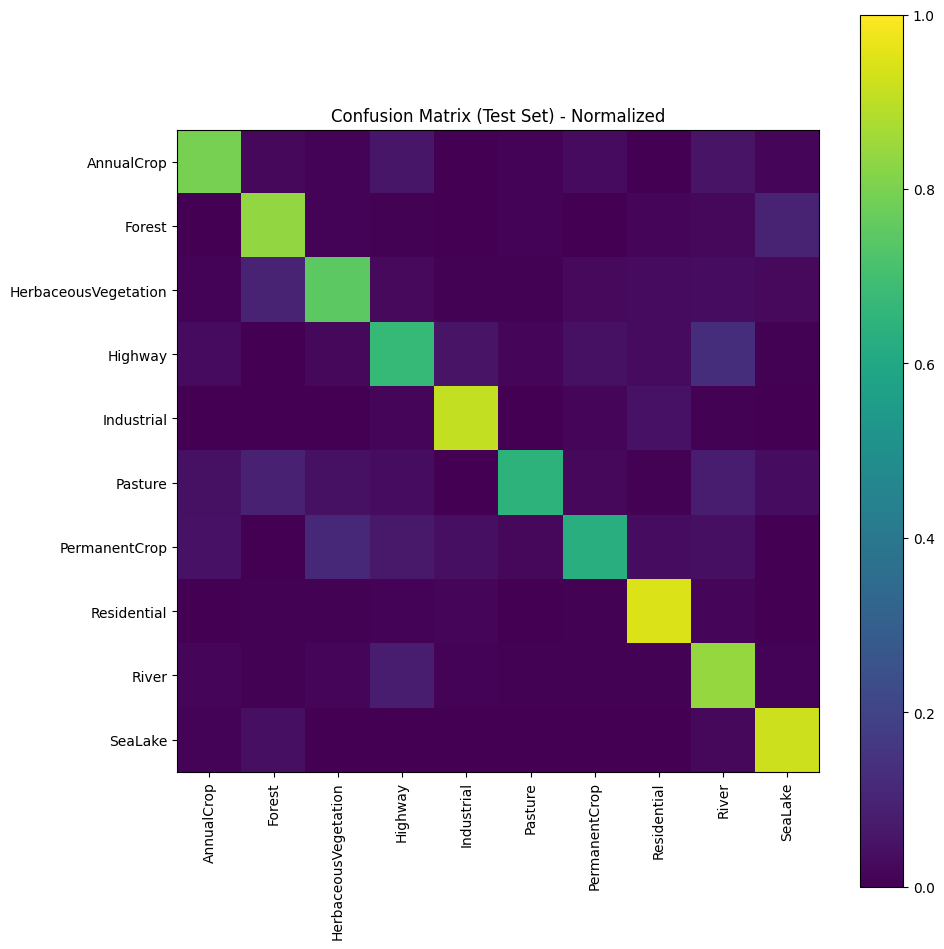

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

fig_dir = PROJECT_ROOT / "reports" / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

cm_np = np.array(cm)

# Normalize rows - each true class sums to 1
cm_norm = cm_np / np.maximum(cm_np.sum(axis=1, keepdims=True), 1)

plt.figure(figsize=(10, 10))
plt.imshow(cm_norm, vmin=0, vmax=1)
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.title("Confusion Matrix (Test Set) - Normalized")
plt.colorbar()
plt.tight_layout()

out_path = fig_dir / "confusion_matrix_resnet18_normalized.png"
plt.savefig(out_path, dpi=200, bbox_inches="tight")
print("Saved:", out_path)

plt.show()

Saved: C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\reports\figures\confusion_matrix_resnet18_raw.png


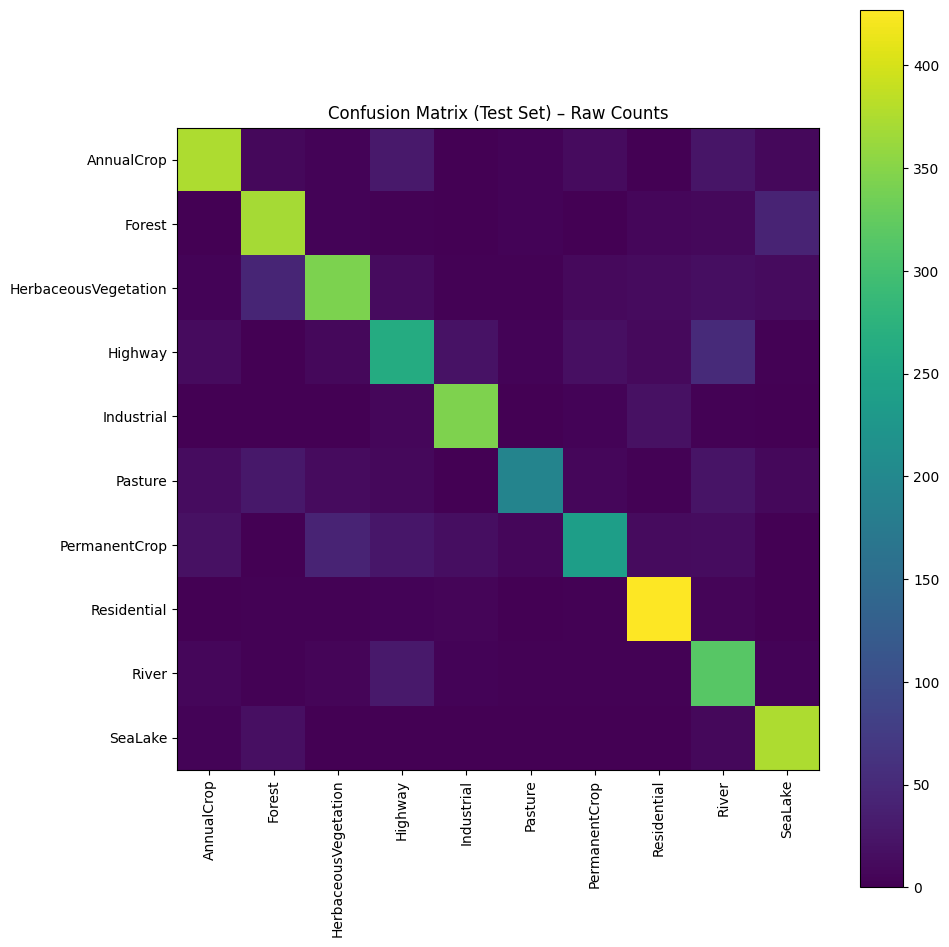

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

fig_dir = PROJECT_ROOT / "reports" / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

cm_np = np.array(cm)

plt.figure(figsize=(10, 10))
plt.imshow(cm_np)
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.title("Confusion Matrix (Test Set) – Raw Counts")
plt.colorbar()
plt.tight_layout()

out_path = fig_dir / "confusion_matrix_resnet18_raw.png"
plt.savefig(out_path, dpi=200, bbox_inches="tight")
print("Saved:", out_path)

plt.show()

Cell 5: Fine-tune

In [7]:
model, class_names = train_model(
    data_dir=DATA_DIR,
    model_name="resnet18",
    pretrained=True,
    freeze_backbone=False,   # fine-tune
    epochs=10,
    lr=1e-4,                 # lower LR for fine-tuning
    batch_size=64,
    img_size=64,
    seed=42,
    aug_level="light",
    weight_decay=1e-4,
    label_smoothing=0.05,
    early_stop_patience=3,
)

Using device: cpu


Epoch 1/10: 100%|██████████| 296/296 [03:11<00:00,  1.55it/s]


Epoch 1 | Train Loss: 0.6523 | Val Acc: 0.9472 | LR: 1.00e-04
Saved BEST model so far to C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\models\resnet18_pre_ft_best.pth (val_acc=0.9472)


Epoch 2/10: 100%|██████████| 296/296 [04:59<00:00,  1.01s/it]


Epoch 2 | Train Loss: 0.4624 | Val Acc: 0.9600 | LR: 1.00e-04
Saved BEST model so far to C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\models\resnet18_pre_ft_best.pth (val_acc=0.9600)


Epoch 3/10: 100%|██████████| 296/296 [03:30<00:00,  1.40it/s]


Epoch 3 | Train Loss: 0.4177 | Val Acc: 0.9654 | LR: 1.00e-04
Saved BEST model so far to C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\models\resnet18_pre_ft_best.pth (val_acc=0.9654)


Epoch 4/10: 100%|██████████| 296/296 [03:27<00:00,  1.43it/s]


Epoch 4 | Train Loss: 0.3992 | Val Acc: 0.9701 | LR: 1.00e-04
Saved BEST model so far to C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\models\resnet18_pre_ft_best.pth (val_acc=0.9701)


Epoch 5/10: 100%|██████████| 296/296 [03:29<00:00,  1.41it/s]


Epoch 5 | Train Loss: 0.3842 | Val Acc: 0.9620 | LR: 1.00e-04


Epoch 6/10: 100%|██████████| 296/296 [04:16<00:00,  1.15it/s]


Epoch 6 | Train Loss: 0.3722 | Val Acc: 0.9694 | LR: 1.00e-04


Epoch 7/10: 100%|██████████| 296/296 [04:54<00:00,  1.00it/s]


Epoch 7 | Train Loss: 0.3669 | Val Acc: 0.9714 | LR: 1.00e-04
Saved BEST model so far to C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\models\resnet18_pre_ft_best.pth (val_acc=0.9714)


Epoch 8/10: 100%|██████████| 296/296 [05:11<00:00,  1.05s/it]


Epoch 8 | Train Loss: 0.3561 | Val Acc: 0.9669 | LR: 1.00e-04


Epoch 9/10: 100%|██████████| 296/296 [04:23<00:00,  1.12it/s]


Epoch 9 | Train Loss: 0.3489 | Val Acc: 0.9738 | LR: 1.00e-04
Saved BEST model so far to C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\models\resnet18_pre_ft_best.pth (val_acc=0.9738)


Epoch 10/10: 100%|██████████| 296/296 [04:36<00:00,  1.07it/s]


Epoch 10 | Train Loss: 0.3425 | Val Acc: 0.9711 | LR: 1.00e-04
Done. Best Val Acc: 0.9738


Cell 6: Find the checkpoint

In [8]:
from pathlib import Path
import os

PROJECT_ROOT = Path(os.getcwd()).resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

models_dir = PROJECT_ROOT / "models"
print("Models folder:", models_dir)

for p in sorted(models_dir.glob("*.pth")):
    print("-", p.name)

Models folder: C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\models
- resnet18_pre_frozen_best.pth
- resnet18_pre_frozen_last.pth
- resnet18_pre_ft_best.pth
- resnet18_pre_ft_last.pth
- simple_cnn.pth
- simple_cnn_augmented.pth
- simple_cnn_v2.pth
- simple_cnn_v2_best.pth
- simple_cnn_v2_last.pth


Cell 7: Evaluation

In [10]:
import torch
from src.dataset import load_eurosat_dataset
from src.models import build_model
from src.eval import evaluate_model

device = "cuda" if torch.cuda.is_available() else "cpu"

train_loader, val_loader, test_loader, class_names = load_eurosat_dataset(
    data_dir=DATA_DIR,
    img_size=64,
    batch_size=64,
    seed=42,
    aug_level="light",
)

MODEL_PATH = PROJECT_ROOT / "models" / "resnet18_pre_ft_best.pth"
print("Loading:", MODEL_PATH)

model = build_model(
    num_classes=len(class_names),
    model_name="resnet18",
    pretrained=True,          # ok for architecture setup
    freeze_backbone=False,    # eval only
).to(device)

model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

test_acc, cm, report = evaluate_model(model, test_loader, class_names, device)
print("Test Accuracy:", round(test_acc, 4))
print(report)


Loading: C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\models\resnet18_pre_ft_best.pth
Test Accuracy: 0.9721
                      precision    recall  f1-score   support

          AnnualCrop     0.9803    0.9470    0.9634       472
              Forest     0.9886    0.9842    0.9864       442
HerbaceousVegetation     0.9614    0.9782    0.9697       458
             Highway     0.9691    0.9616    0.9653       391
          Industrial     0.9714    0.9894    0.9803       378
             Pasture     0.9633    0.9666    0.9649       299
       PermanentCrop     0.9430    0.9604    0.9516       379
         Residential     0.9955    0.9733    0.9843       450
               River     0.9576    0.9627    0.9601       375
             SeaLake     0.9830    0.9975    0.9902       406

            accuracy                         0.9721      4050
           macro avg     0.9713    0.9721    0.9716      4050
        weighted avg     0.9723    0.9721    0.9721      4050



Cell 8

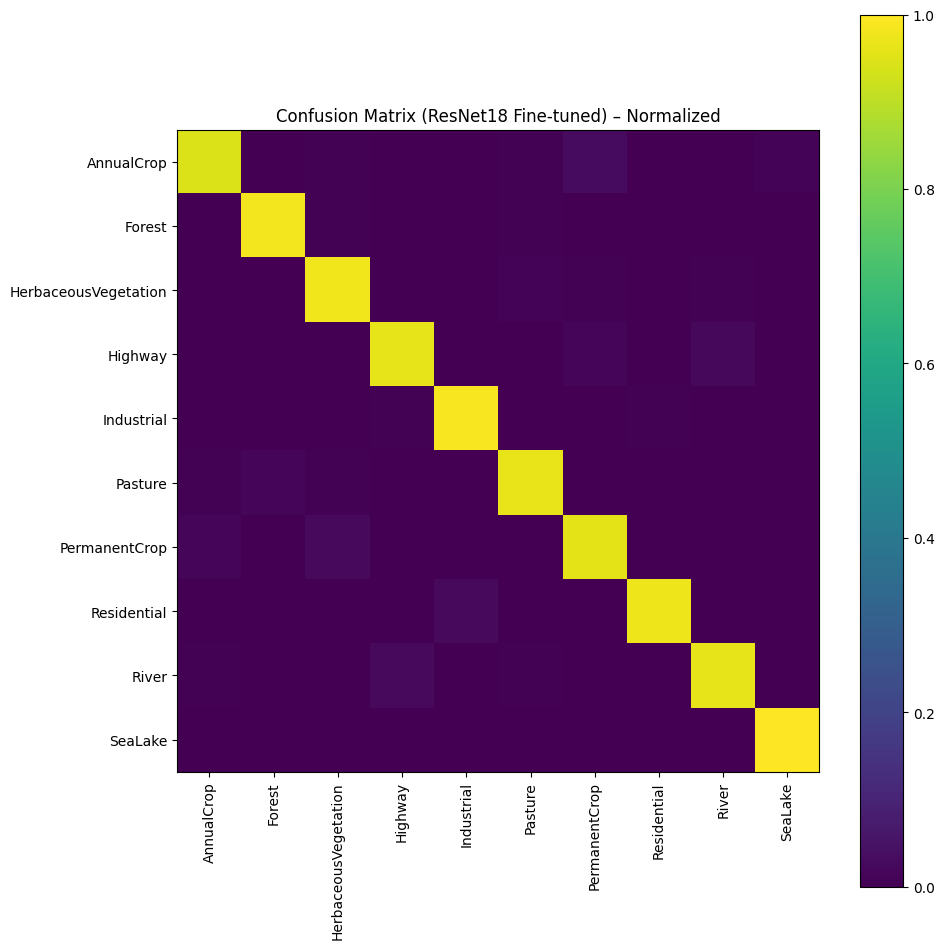

Saved: C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\reports\figures\confusion_matrix_resnet18_ft_normalized.png


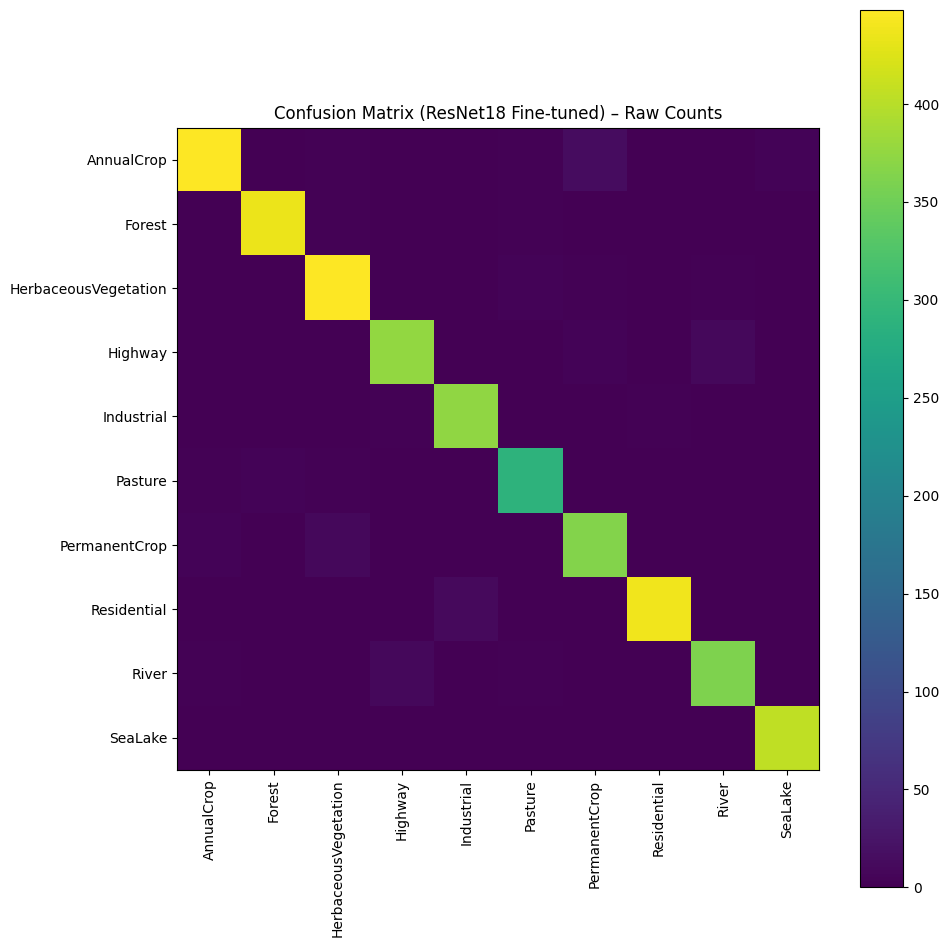

Saved: C:\Users\adamc\Documents\Projects\GeoAI-LandUse-Model\reports\figures\confusion_matrix_resnet18_ft_raw.png


In [11]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Output directory
fig_dir = PROJECT_ROOT / "reports" / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

cm_np = np.array(cm)

# Normalized confusion matrix
cm_norm = cm_np / np.maximum(cm_np.sum(axis=1, keepdims=True), 1)

plt.figure(figsize=(10, 10))
plt.imshow(cm_norm, vmin=0, vmax=1)
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.title("Confusion Matrix (ResNet18 Fine-tuned) – Normalized")
plt.colorbar()
plt.tight_layout()

norm_path = fig_dir / "confusion_matrix_resnet18_ft_normalized.png"
plt.savefig(norm_path, dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", norm_path)

# Raw confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm_np)
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.title("Confusion Matrix (ResNet18 Fine-tuned) – Raw Counts")
plt.colorbar()
plt.tight_layout()

raw_path = fig_dir / "confusion_matrix_resnet18_ft_raw.png"
plt.savefig(raw_path, dpi=200, bbox_inches="tight")
plt.show()

print("Saved:", raw_path)